In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
from captum.attr import IntegratedGradients
import seaborn as sns


In [9]:
# Hyperparameters
LOOKBACK = 14
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.2
MC_RUNS = 15

In [3]:
# Load datasets
train_df = pd.read_csv("../data/DailyDelhiClimateTrain.csv")
test_df = pd.read_csv("../data/DailyDelhiClimateTest.csv")

# Preprocess
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])
print("Data loaded and scaled.")
print(train_scaled.shape, test_scaled.shape)

Data loaded and scaled.
(1462, 4) (114, 4)


In [4]:
# Function to create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i][0])  # meantemp
    return np.array(X), np.array(y)

X_train_all, y_train_all = create_sequences(train_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

In [5]:
# LSTM Model
class LSTMModel(nn.Module):
    # def __init__(self, input_size, hidden_size=50):
    def __init__(self, input_size, hidden_size=128, num_layers=2):  # increased hidden_size and num_layers
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last time step
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = LSTMModel(input_size=4).to(device)
model = LSTMModel(input_size=4, hidden_size=128, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [6]:
# filepath: d:\Dropbox\Fraunhofer\MA_copy\climate\code\climate_train_new.ipynb
model.load_state_dict(torch.load("../result/lstm_weather_model.pth"))
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


LSTMModel(
  (lstm): LSTM(4, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
class MCDropoutWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        self.model.train()  # keep dropout active even during inference
        return self.model(x)

# SHAP names
# shap_feature_names = [f"t-{i // 4 + 1}_{features[i % 4]}" for i in range(LOOKBACK * 4)]
shap_feature_names = [f"t-{LOOKBACK - i // 4}_{features[i % 4]}" for i in range(LOOKBACK * 4)]
print("SHAP feature names:", shap_feature_names)

# Collect multiple stochastic forward passes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=4).to(device)
mc_model = MCDropoutWrapper(model)

SHAP feature names: ['t-14_meantemp', 't-14_humidity', 't-14_wind_speed', 't-14_meanpressure', 't-13_meantemp', 't-13_humidity', 't-13_wind_speed', 't-13_meanpressure', 't-12_meantemp', 't-12_humidity', 't-12_wind_speed', 't-12_meanpressure', 't-11_meantemp', 't-11_humidity', 't-11_wind_speed', 't-11_meanpressure', 't-10_meantemp', 't-10_humidity', 't-10_wind_speed', 't-10_meanpressure', 't-9_meantemp', 't-9_humidity', 't-9_wind_speed', 't-9_meanpressure', 't-8_meantemp', 't-8_humidity', 't-8_wind_speed', 't-8_meanpressure', 't-7_meantemp', 't-7_humidity', 't-7_wind_speed', 't-7_meanpressure', 't-6_meantemp', 't-6_humidity', 't-6_wind_speed', 't-6_meanpressure', 't-5_meantemp', 't-5_humidity', 't-5_wind_speed', 't-5_meanpressure', 't-4_meantemp', 't-4_humidity', 't-4_wind_speed', 't-4_meanpressure', 't-3_meantemp', 't-3_humidity', 't-3_wind_speed', 't-3_meanpressure', 't-2_meantemp', 't-2_humidity', 't-2_wind_speed', 't-2_meanpressure', 't-1_meantemp', 't-1_humidity', 't-1_wind_speed',

In [10]:
# SHAP setup
shap_feature_names = [f"t-{i//4+1}_{features[i%4]}" for i in range(LOOKBACK * 4)]

X_input = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

# Run MC Dropout prediction
mc_outputs = []
for _ in range(MC_RUNS):
    preds = mc_model(X_input).cpu().detach().numpy()  # [samples, 1]
    mc_outputs.append(preds)

mc_outputs = np.stack(mc_outputs, axis=0).squeeze(-1)  # [runs, samples]
predictive_variance = np.var(mc_outputs, axis=0)  # [samples]

In [19]:
print("Predictive variance shape:", predictive_variance.shape)

Predictive variance shape: (100,)


In [15]:
# Run SHAP on predictive variance
explainer = shap.Explainer(lambda x: np.var(
    np.stack([
        mc_model(torch.tensor(x, dtype=torch.float32).view(-1, LOOKBACK, 4).to(device)).cpu().detach().numpy()
        for _ in range(MC_RUNS)
    ], axis=0).squeeze(-1), axis=0
), X_test[:100].reshape(100, -1))

print("SHAP explainer created.", explainer)

SHAP explainer created. shap.explainers.PermutationExplainer()


SHAP values single shape: (1, 56) (1,)


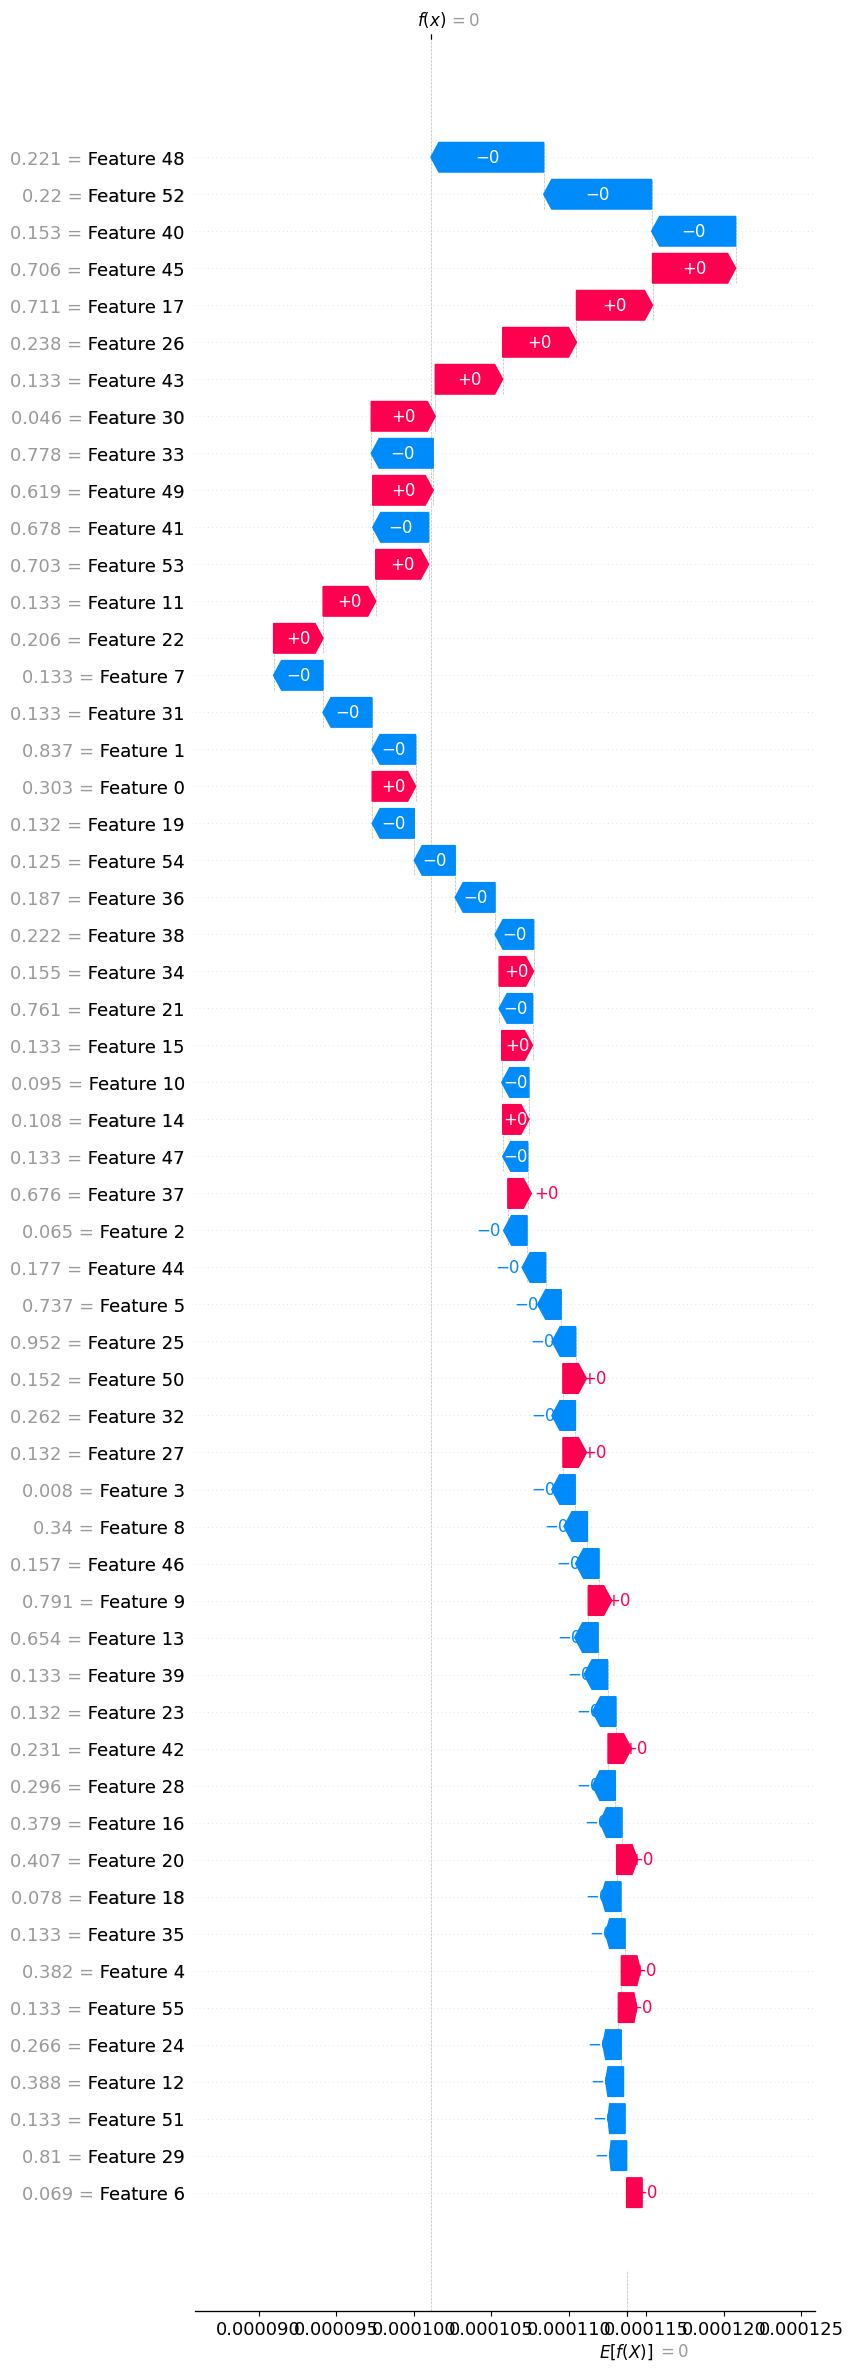

In [16]:
# # SHAP explainer
# explainer = shap.Explainer(model_predict, X_test[:50].reshape(50, -1))

# One sample explanation
shap_values_single = explainer(X_test[0].reshape(1, -1))
# print("SHAP values single:", shap_values_single.base_values, shap_values_single, )
print("SHAP values single shape:", shap_values_single.shape, shap_values_single.base_values.shape)

shap_values_single[0].feature_names = shap_feature_names  # override default feature names
shap_values_single[0].display_data = X_test[0].reshape(1, -1)  # make sure input values are shown correctly
shap.plots.waterfall(shap_values_single[0], max_display=14*4)

PermutationExplainer explainer: 101it [03:33,  2.20s/it]                         


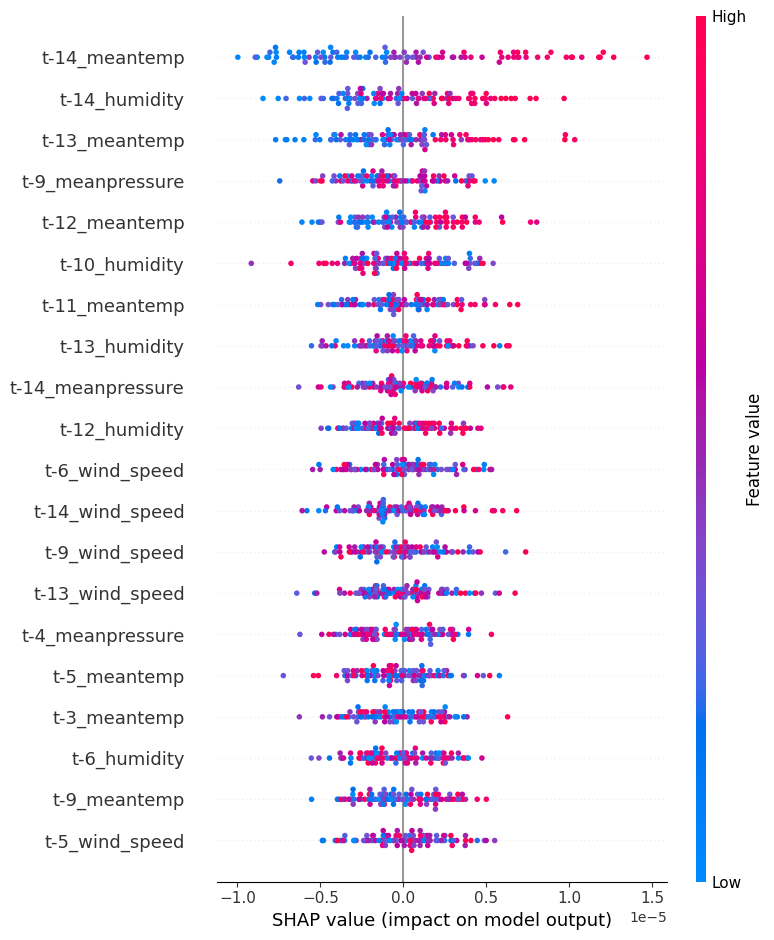

In [ ]:
shap_values_var = explainer(X_test[:100].reshape(100, -1))
shap.summary_plot(shap_values_var, X_test[:100].reshape(100, -1), feature_names=shap_feature_names)

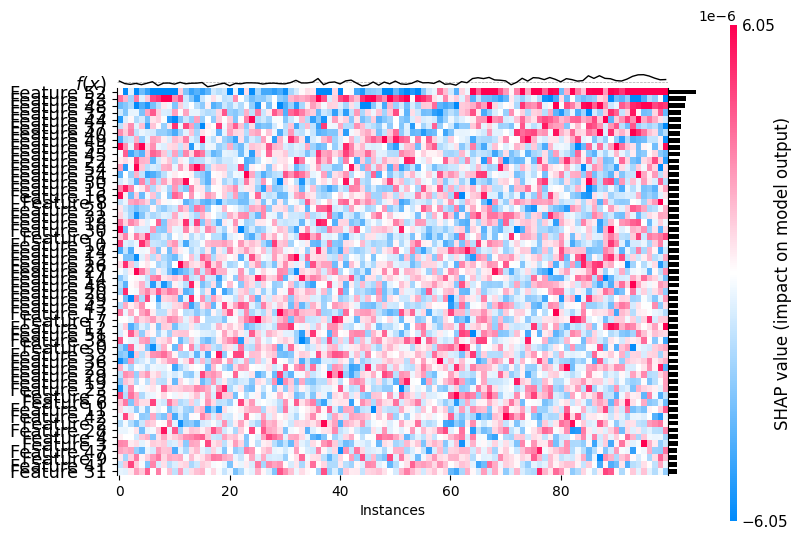

In [13]:
shap.plots.heatmap(shap_values_var, max_display=14*4, show=True)

Reshaped SHAP values shape: (100, 14, 4)
Highest contributing feature: meantemp on day t-1


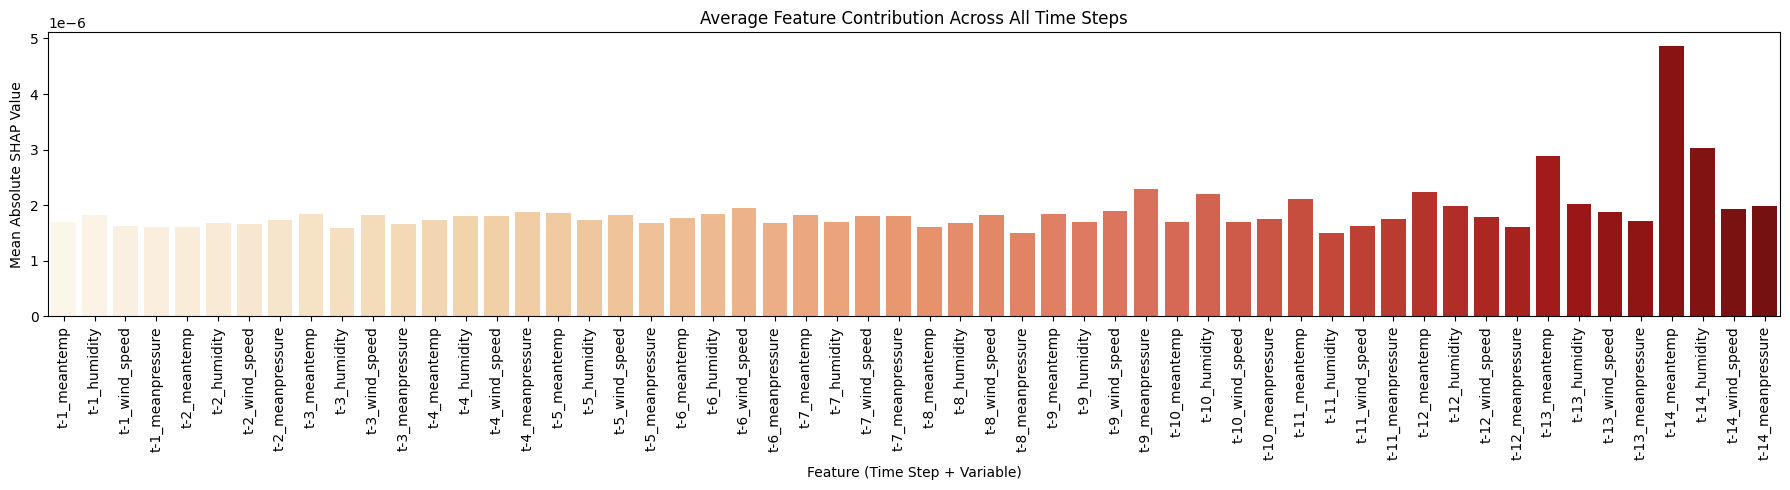

In [18]:
# Reshape SHAP values: [samples, LOOKBACK, features]
reshaped = shap_values_var.values.reshape(-1, LOOKBACK, 4)
print("Reshaped SHAP values shape:", reshaped.shape)  # shape: (40, LOOKBACK, 4)
mean_abs_vals = np.abs(reshaped).mean(axis=0)  # shape: (LOOKBACK, 4)

# Get max contributing feature and day
day_idx, feat_idx = np.unravel_index(mean_abs_vals.argmax(), mean_abs_vals.shape)
feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

print(f"Highest contributing feature: {feature_names[feat_idx]} on day t-{LOOKBACK - day_idx}")

import warnings
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

# shap_feature_names = [f"t-{LOOKBACK - i // 4}_{features[i % 4]}" for i in range(LOOKBACK * 4)]
# print("Detailed feature names:", shap_feature_names)

# mean_abs_vals 形状是 (LOOKBACK, 4)，flatten后和detailed_feature_names一一对应
plt.figure(figsize=(18, 5))
# sns.barplot(x=detailed_feature_names, y=mean_abs_vals.flatten(), palette="Blues_d") # 
sns.barplot(x=shap_feature_names, y=mean_abs_vals.flatten(),  hue=shap_feature_names, palette="OrRd", legend=False)
plt.title("Average Feature Contribution Across All Time Steps")
plt.ylabel("Mean Absolute SHAP Value")
plt.xlabel("Feature (Time Step + Variable)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

(100, 56)


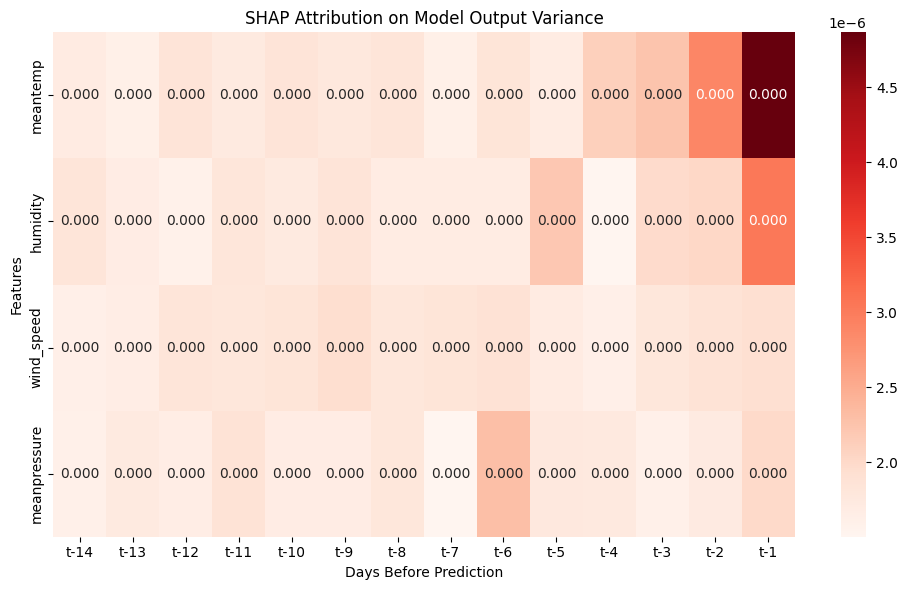

Top 10 features contributing to model output variance:
t-14_meantemp: 0.000005
t-14_humidity: 0.000003
t-13_meantemp: 0.000003
t-9_meanpressure: 0.000002
t-12_meantemp: 0.000002
t-10_humidity: 0.000002
t-11_meantemp: 0.000002
t-13_humidity: 0.000002
t-14_meanpressure: 0.000002
t-12_humidity: 0.000002




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


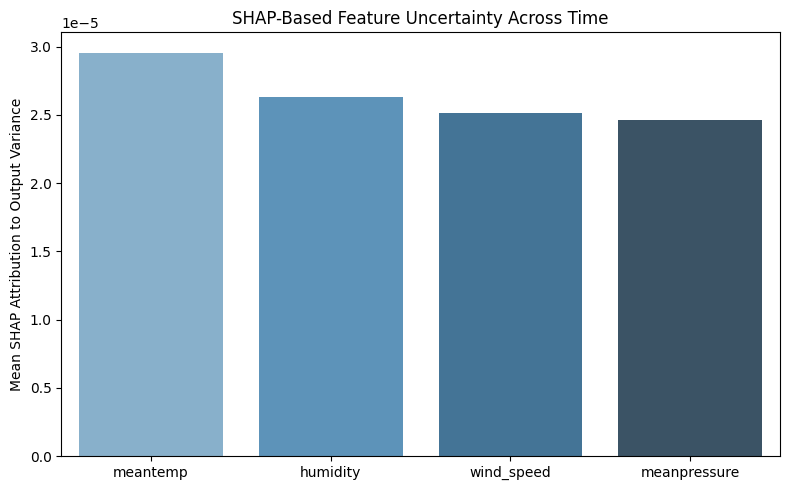

In [17]:
print(shap_values_var.shape)

# SHAP heatmap
reshaped_var = shap_values_var.values.reshape(-1, LOOKBACK, 4)
mean_var_vals = np.abs(reshaped_var).mean(axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(mean_var_vals.T, xticklabels=[f"t-{LOOKBACK-i}" for i in range(LOOKBACK)], yticklabels=features, annot=True, fmt=".3f", cmap="Reds")
plt.title("SHAP Attribution on Model Output Variance")
plt.xlabel("Days Before Prediction")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Top 10 contributing features
flat_vals = np.abs(shap_values_var.values).mean(axis=0)
sorted_idx = np.argsort(flat_vals)[::-1]

print("Top 10 features contributing to model output variance:")
for i in range(10):
    print(f"{shap_feature_names[sorted_idx[i]]}: {flat_vals[sorted_idx[i]]:.6f}")

# Aggregate feature-level uncertainty (mean across time steps)
feature_uncertainty = mean_var_vals.sum(axis=0)  # shape: [4]

# Bar chart visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=features, y=feature_uncertainty, palette="Blues_d", legend=False)
plt.title("SHAP-Based Feature Uncertainty Across Time")
plt.ylabel("Mean SHAP Attribution to Output Variance")
plt.tight_layout()
plt.show()